In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:

# Replace this with your actual parent directory
PARENT_LOG_DIR = "data/training_result/"

def extract_scalars_from_event(event_path):
    ea = EventAccumulator(event_path)
    ea.Reload()
    
    all_scalars = []
    tags = ea.Tags().get('scalars', [])
    
    for tag in tags:
        events = ea.Scalars(tag)
        for event in events:
            all_scalars.append({
                "tag": tag,
                "step": event.step,
                "wall_time": event.wall_time,
                "value": event.value
            })
    return all_scalars

all_data = []

for model_dir in os.listdir(PARENT_LOG_DIR):
    full_path = os.path.join(PARENT_LOG_DIR, model_dir)
    if not os.path.isdir(full_path):
        continue

    # Search for event files in this model directory
    for root, dirs, files in os.walk(full_path):
        for file in files:
            if "tfevents" in file:
                event_file = os.path.join(root, file)
                scalars = extract_scalars_from_event(event_file)
                for entry in scalars:
                    entry["model"] = model_dir
                all_data.extend(scalars)

In [3]:
df = pd.DataFrame(all_data)

Available tags:

Replace '-' with train or val

- lr-AdamW
- -/f1
- -/f1/grassland_shrubland
- -/f1/logging
- -/f1/mining
- -/f1/plantation
- val/loss_epoch
- val/loss_step
- train/loss


In [4]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
img_folder = Path("./report/imgs/")

In [5]:
def create_plot(tag, channels, title, save_path=None):
    model_names = [m for m in df["model"].unique() if m.endswith(channels)]
    color_map = {m: c for m,c in zip(model_names, colors)}
    for model_name in df["model"].unique():
        if model_name.endswith(channels): 
            test = df.where(df["tag"]==tag).where(df["model"]==model_name).dropna().sort_values("step")
            plt.plot(test["step"], test["value"], label=model_name, color=color_map[model_name])
    plt.title(title)
    if "f1" in tag:
        plt.ylim(top=1, bottom=0)
    plt.ylabel("Value")
    plt.xlabel("Steps")
    plt.legend(framealpha=0.5)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

In [6]:
def plot_tags_grid(tags, channels, title, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    model_names = [m for m in df["model"].unique() if m.endswith(channels)]
    lines = []
    color_map = {m: c for m,c in zip(model_names, colors)}

    for i, tag in enumerate(tags):
        ax = axes[i]
        for model_name in df["model"].unique():
            if model_name.endswith(channels):
                test = df.where(df["tag"] == tag).where(df["model"] == model_name).dropna().sort_values("step")
                line, = ax.plot(test["step"], test["value"], label=model_name, color=color_map[model_name])
                if i == 0:
                    lines.append(line)

        ax.set_title(tag)
        if "f1" in tag:
            ax.set_ylim(0, 1)

    # Common X and Y labels
    fig.text(0.5, 0.01, 'Steps', ha='center', fontsize=12)
    fig.text(0.01, 0.5, 'Value', va='center', rotation='vertical', fontsize=12)

    fig.legend(lines, model_names, loc='lower center', ncol=len(model_names), bbox_to_anchor=(0.5, -0.05))

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0.05, 0.08, 1, 1])
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

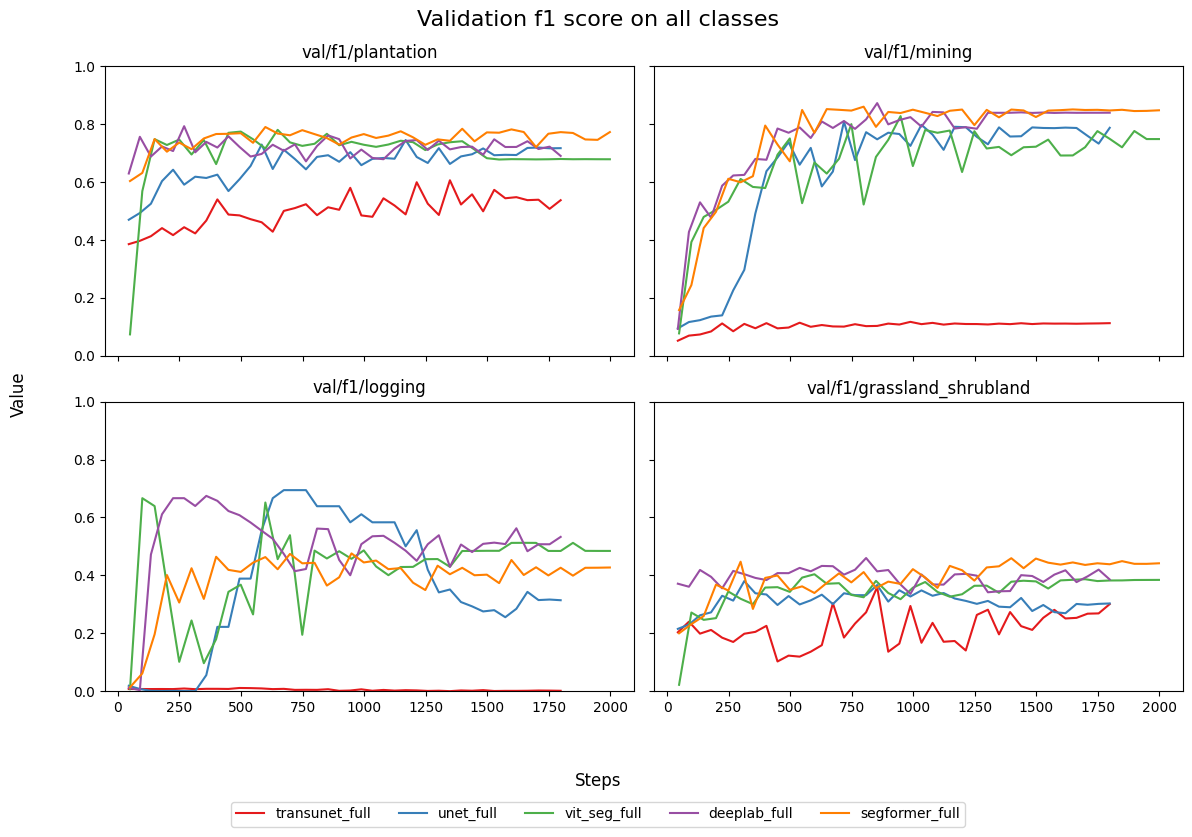

In [7]:
plot_tags_grid(["val/f1/plantation", "val/f1/mining", "val/f1/logging", "val/f1/grassland_shrubland"], "full", "Validation f1 score on all classes", save_path=img_folder/"val_f1_classes.png")

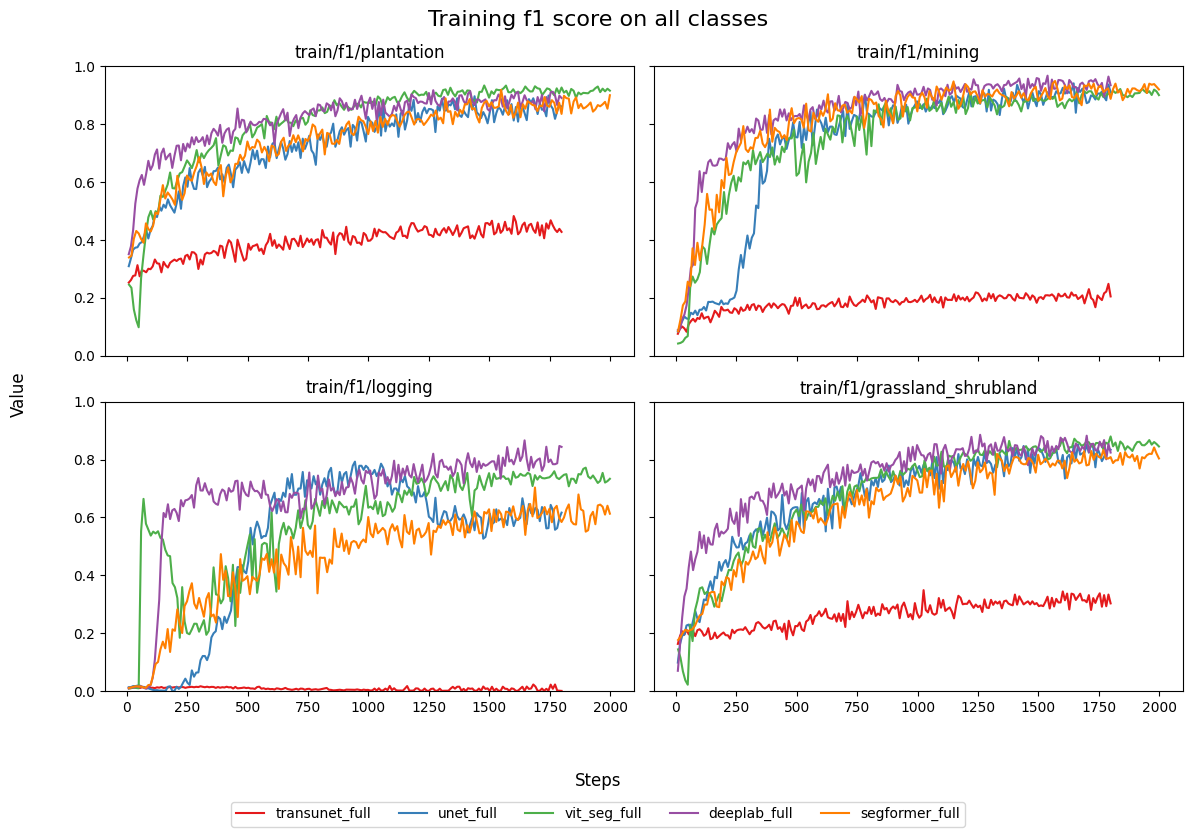

In [8]:
plot_tags_grid(["train/f1/plantation", "train/f1/mining", "train/f1/logging", "train/f1/grassland_shrubland"], "full", "Training f1 score on all classes", save_path=img_folder/"train_f1_classes.png")

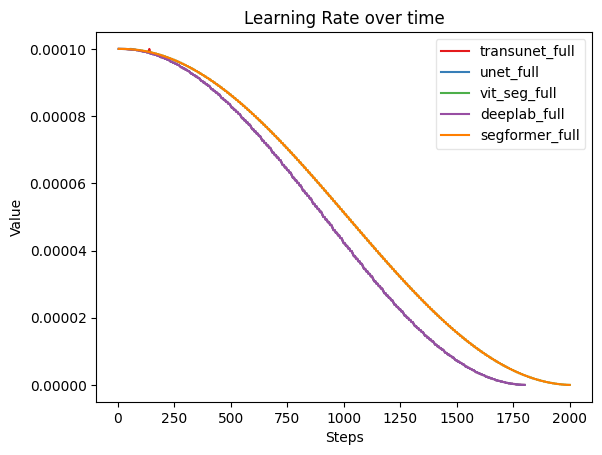

In [9]:
create_plot("lr-AdamW", "full", "Learning Rate over time", save_path=img_folder/"lr.png")

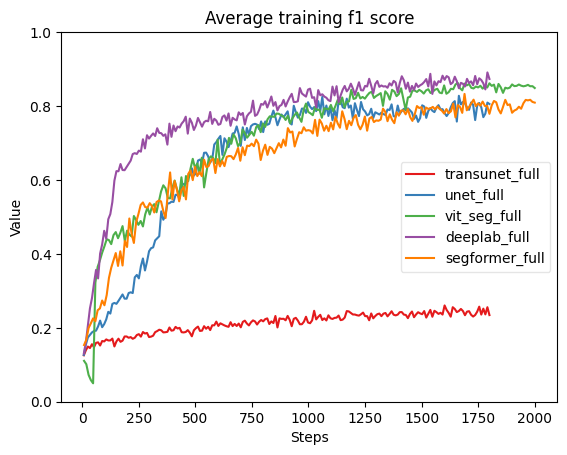

In [10]:
create_plot("train/f1", "full", "Average training f1 score", save_path=img_folder/"train_f1.png")

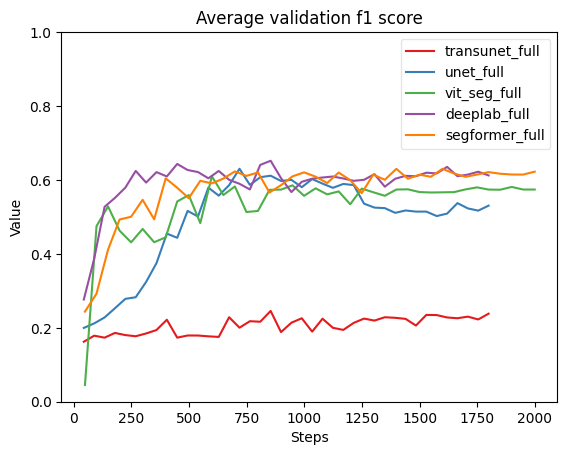

In [11]:
create_plot("val/f1", "full", "Average validation f1 score", save_path=img_folder/"val_f1.png")